# **Doenças Cardiovasculares com Regressão Logística**


Nesse projeto será construido um modelo que ajuda a prever doenças cardiovasculares. O objetivo é utilizar dados históricos dos pacientes e construir um bom modelo de regressão capaz de indicar se novos pacientes estão propensos a doenças cariovasculares ou não, a base contém os seguintes dados:


age - idade dos pacientes

gender - genero (2 mulheres) (1 homens)

height - altura dos pacientes

weight - peso dos pacientes

gluc - glicose

smoke - fumante (1) não fumante (0)

alco - consume alcool (1) não consome (0)

active - realiza atividades fisicas (1) não realiza (0)

cardio_disease - tem doença cardio (1) não tem (0) - Variável target


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score, classification_report, confusion_matrix
import sys
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)
sys.path.append('../')

from src.EDA import boxplot, outliers_iqr, histograma, plot_categoricas, categoricasXtarget, correlacao, distribuicao_target

## **Carregando e tratando a base de dados**
Verifcando os tipos de dados, se há dados faltantes e outliers.

In [2]:
base = pd.read_csv("../base/CARDIO_BASE.csv", sep=";")

In [3]:
# renomeando colunas para portugues
base = base.rename(columns={
    "age": "idade",
    "height": "altura",
    "gender": "genero",
    "weight": "peso",
    "cholesterol": "colesterol",
    "cardio_disease": "doenca cardiaca", 
    "gluc": "glicose",
    "smoke": "fumante",
    "alco": "alcool",
    "active": "ativo"
})

base.head()

,idade,genero,altura,peso,colesterol,glicose,fumante,alcool,ativo,doenca cardiaca
0,50,2,168,62,1,1,0,0,1,0
1,55,1,156,85,3,1,0,0,1,1
2,52,1,165,64,3,1,0,0,0,1
3,48,2,169,82,1,1,0,0,1,1
4,48,1,156,56,1,1,0,0,0,0


In [4]:
# analisando os dados
print("\nEstatísticas descritivas das colunas numéricas:\n")
print(base[['idade', 'altura', 'peso', 'colesterol', 'glicose']].describe())
print("\n")

print("\nTipos de dados das colunas:")
print(base.dtypes)
print("\n")

print("Porcentagem de nulos")
print(f"{base.isnull().sum() * 100}")



Estatísticas descritivas das colunas numéricas:

              idade        altura    colesterol       glicose
count  10000.000000  10000.000000  10000.000000  10000.000000
mean      53.288300    164.308200      1.365000      1.222200
std        6.796234      8.178796      0.677658      0.565561
min       30.000000     70.000000      1.000000      1.000000
25%       48.000000    159.000000      1.000000      1.000000
50%       54.000000    165.000000      1.000000      1.000000
75%       58.000000    170.000000      2.000000      1.000000
max       65.000000    250.000000      3.000000      3.000000



Tipos de dados das colunas:
idade               int64
genero              int64
altura              int64
peso               object
colesterol          int64
glicose             int64
fumante             int64
alcool              int64
ativo               int64
doenca cardiaca     int64
dtype: object


Porcentagem de nulos
idade              0
genero             0
altura             0
p

In [5]:
# mudando pesol para float
base["peso"] = base["peso"].str.replace(",", ".").astype(float)

## **Analise Exploratória dos Dados**

### **Analise Univariada**

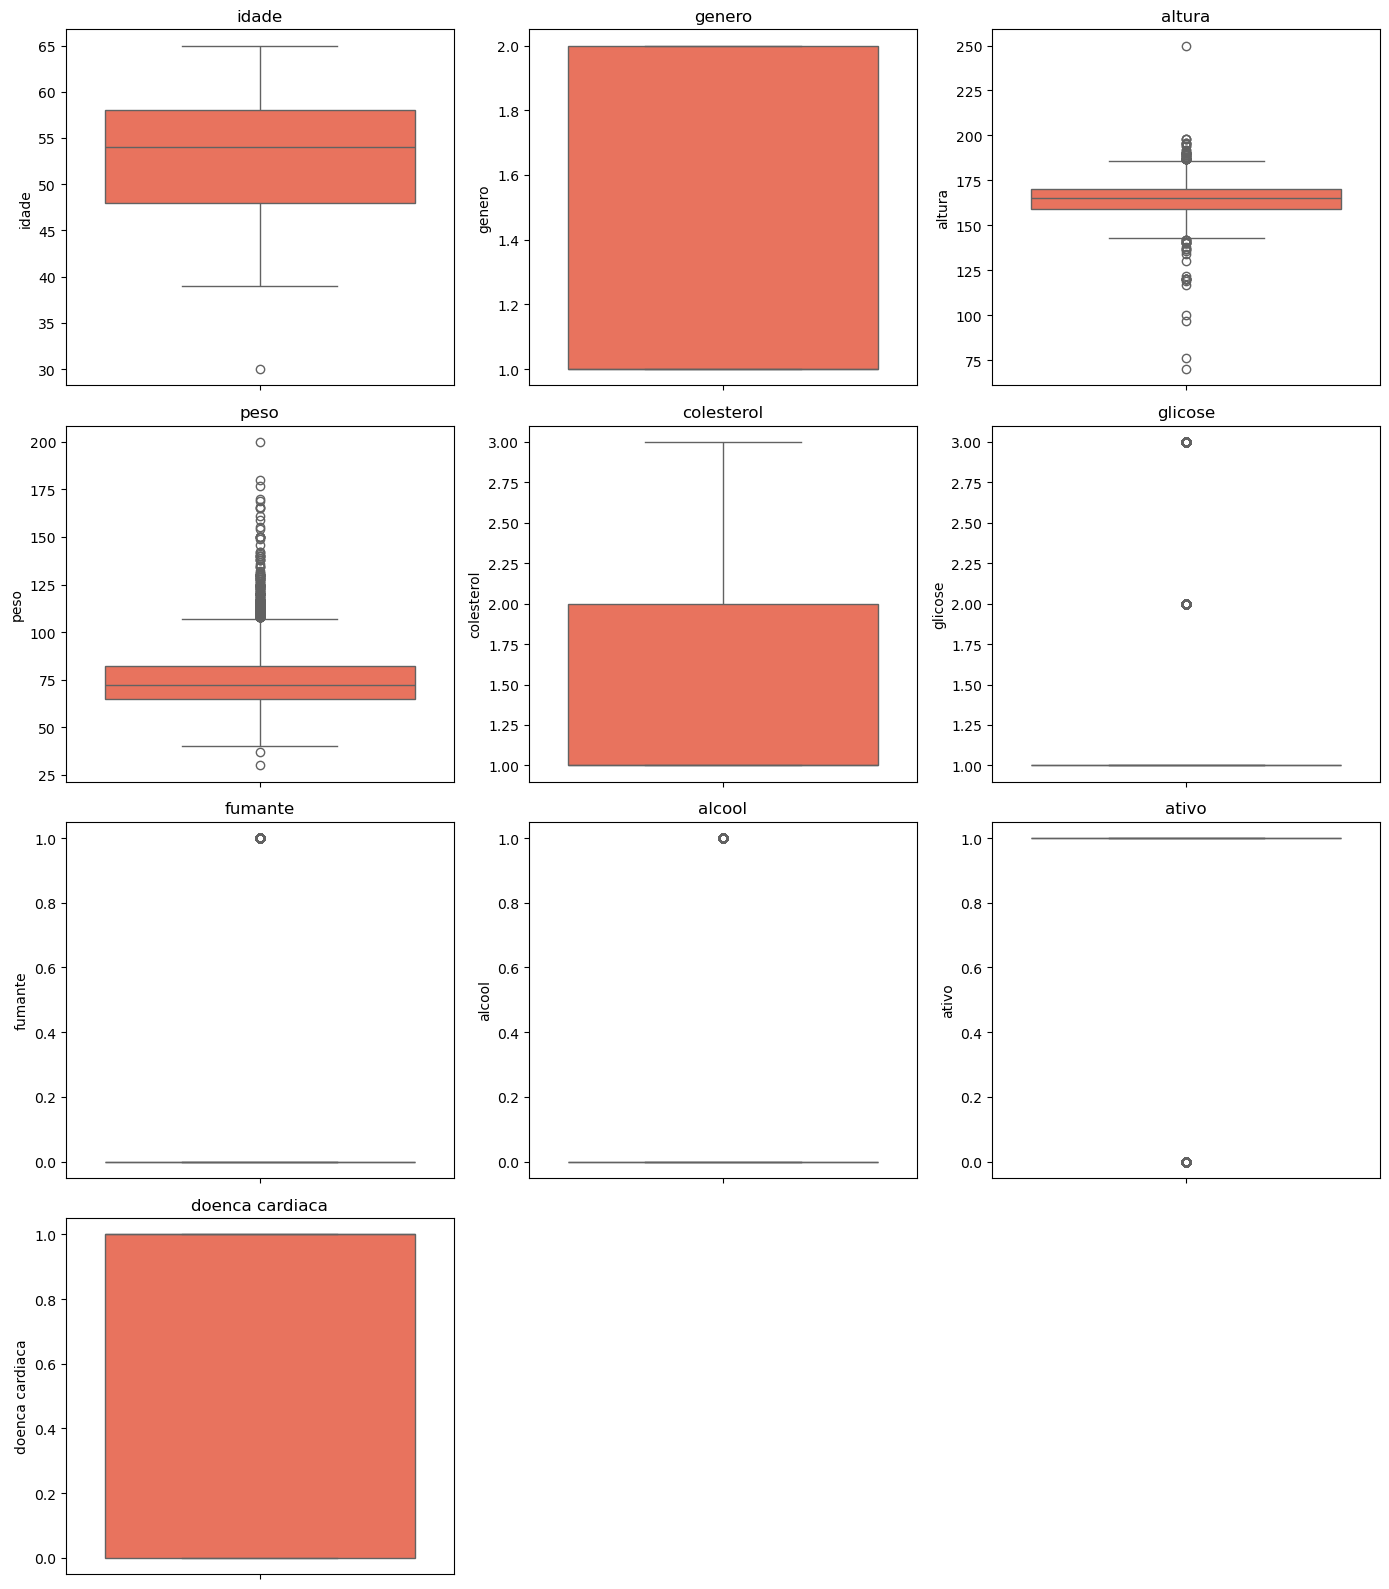

In [6]:
# verificando outiliers
boxplot(base)

Após a análise dos boxplots, foi possível identificar a presença de outliers, sendo alguns valores legítimos e outros apenas anomalias. Dessa forma, decidiu-se remover da base as pessoas com altura inferior a 1,40 m, superior a 2,30 m e aquelas com peso abaixo de 40 kg.
Mesmo apenas com a visualização por boxplot, já é possível extrair algumas observações sobre os dados, por exemplo, a maior parte das pessoas com doenças cardíacas é fisicamente ativa, não consome álcool e não fuma, algo que, a primeira vista, não seria o esperado.

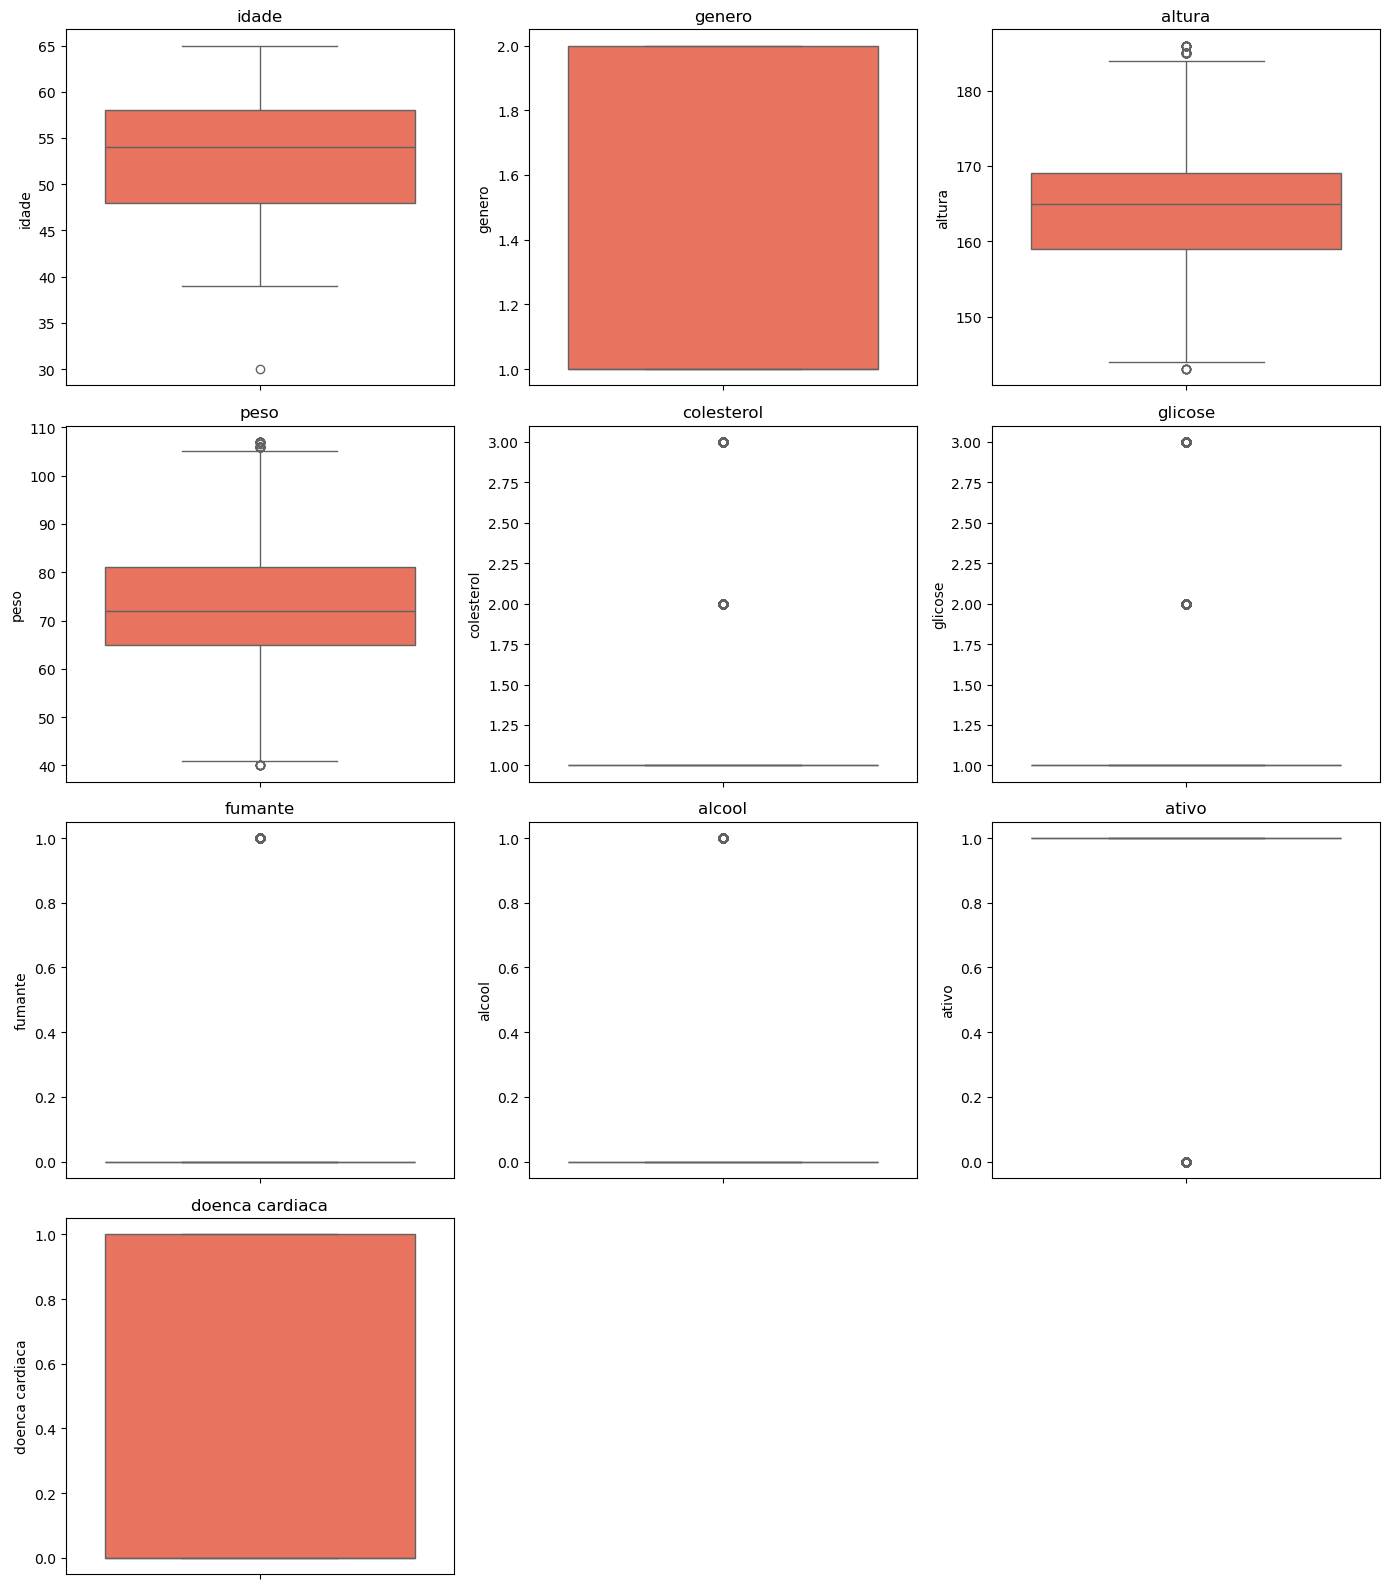

In [7]:
# removendo outliers
# base = base[(base["altura"] >= 140) & (base["altura"] <= 230)]
# base = base[(base["peso"] >= 40)]

# removendo outliers das colunas maior quantidade de outliers
base = outliers_iqr(base, ["altura", "peso"])

# verificando outliers novamente - apenas colunas contínuas
boxplot(base)

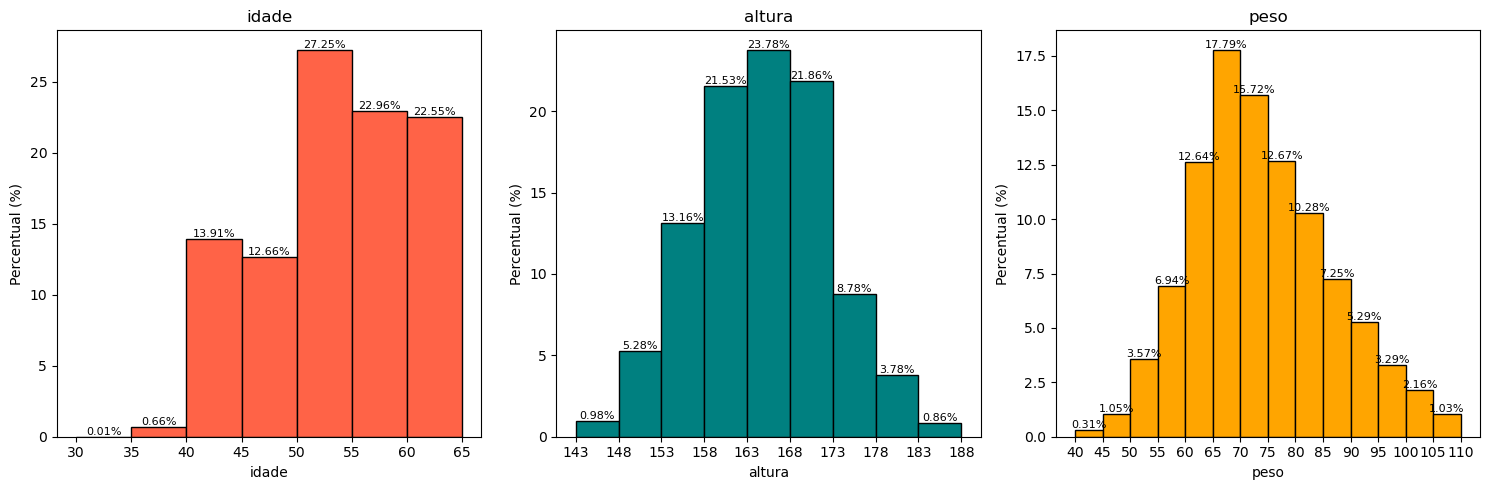

In [8]:
# histograma 
histograma(base, ['idade', 'altura', 'peso'])

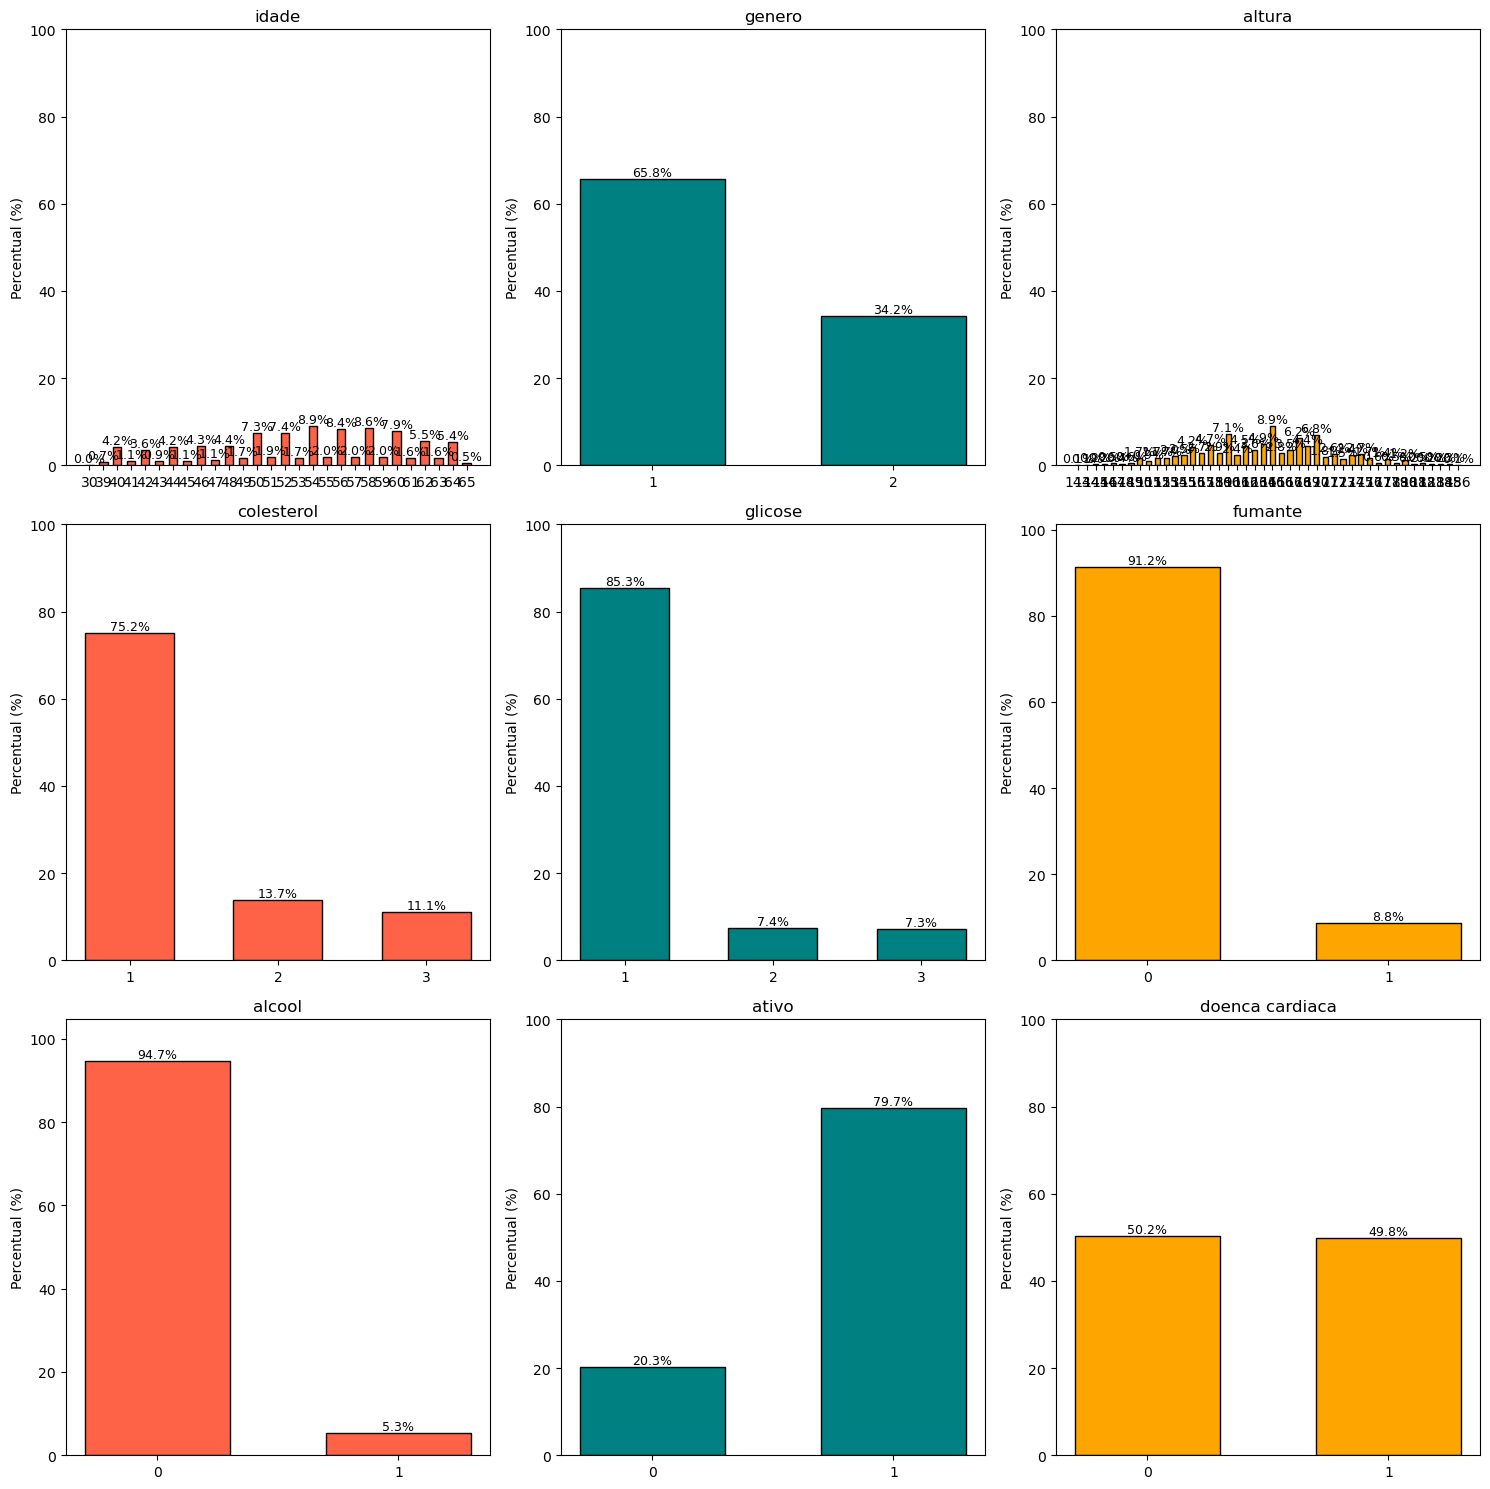

In [9]:
plot_categoricas(base)

Observa-se que a maioria das variáveis categóricas apresenta distribuições distintas e desequilibradas; entretanto, esse fato não implica necessariamente em impacto negativo na performance dos modelos preditivos. A variável Target encontra-se balanceada, portanto, não há necessidade de aplicar técnicas de reamostragem.

### **Analise Bivariada**

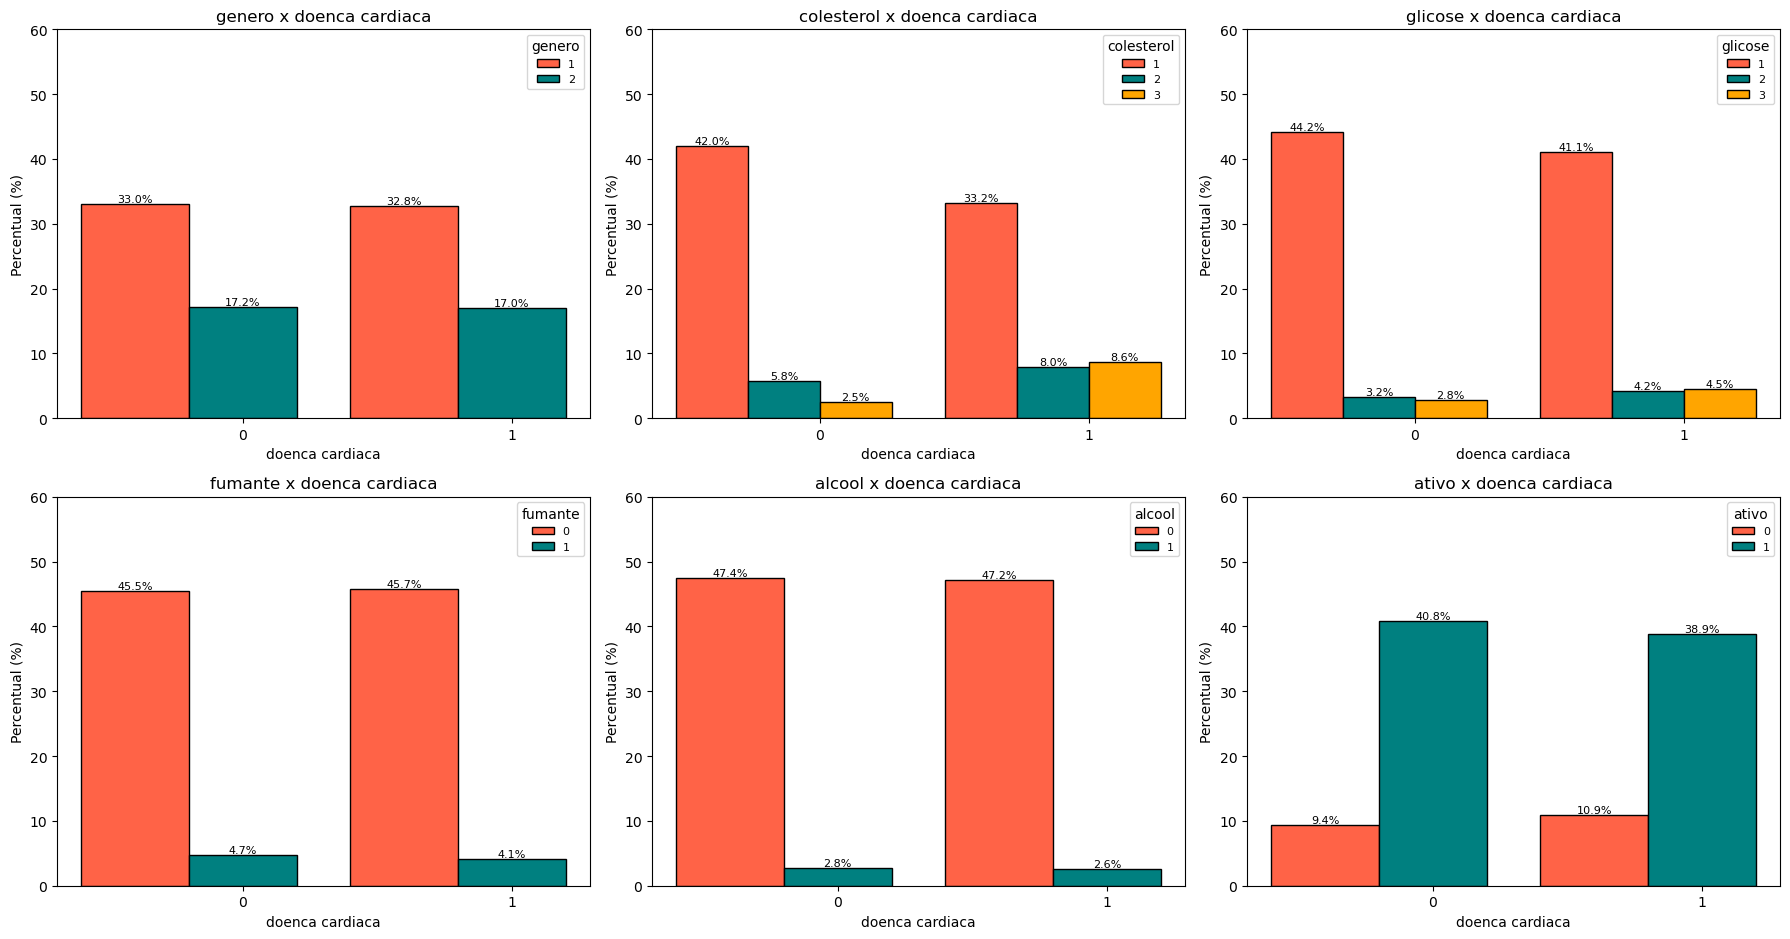

In [10]:
categoricasXtarget(base, 'doenca cardiaca', ['genero', 'colesterol', 'glicose', 'fumante', 'alcool', 'ativo'])

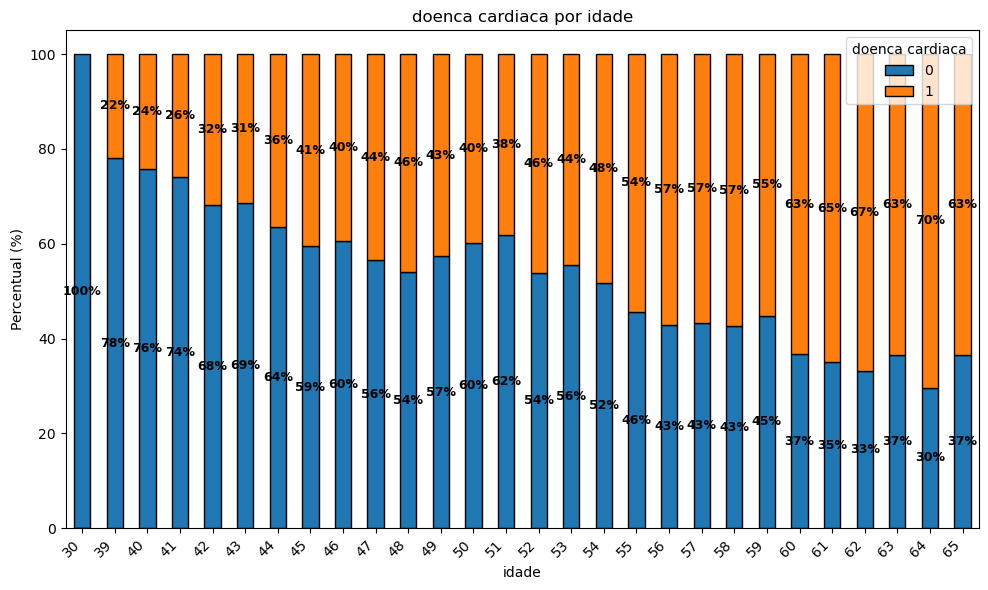

In [11]:
distribuicao_target(base, 'doenca cardiaca', 'idade')

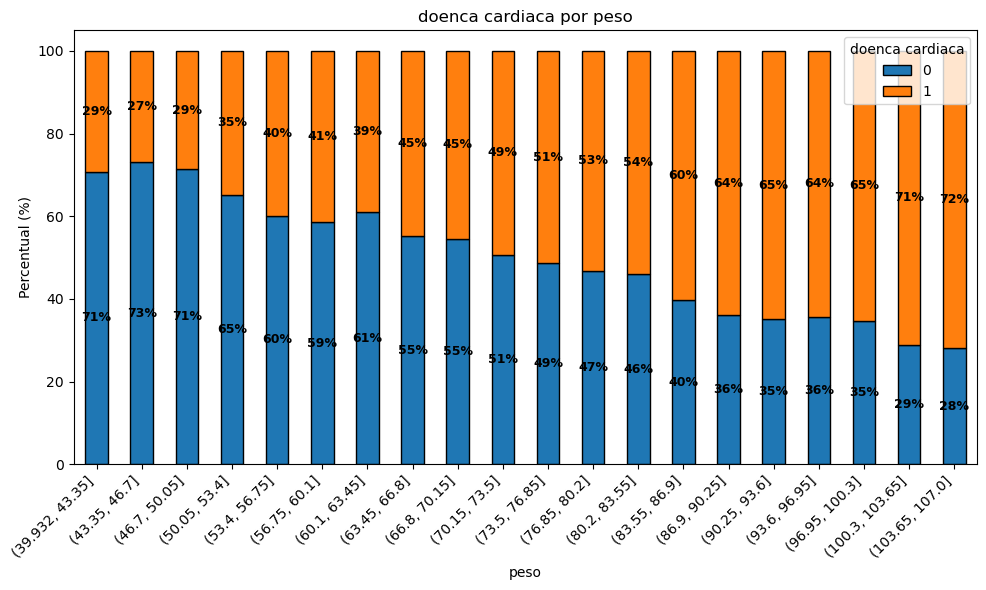

In [12]:
distribuicao_target(base, 'doenca cardiaca', 'peso', bins=20)

A análise mostra que o risco cardiovascular aumenta com a idade, ultrapassando 60% a partir dos 60 anos.

Entre os fatores clínicos, colesterol elevado triplica o risco, enquanto o diabetes aumenta em cerca de 1,6 vez.

Nos fatores comportamentais, tabagismo e consumo de álcool não se mostraram significativos, possivelmente devido ao desequilíbrio na amostra. Por outro lado, a inatividade física está associada a um aumento de aproximadamente 13% na incidência de doenças cardiovasculares.

Em resumo, obesidade, colesterol alto e diabetes se destacam como os principais preditores de doenças cardiovasculares nesta amostra.

### **Matriz de Correlação e Insights**



In [13]:
 # codificação e reordenamento de colunas
df = pd.get_dummies(base,columns=['glicose'],prefix='glicose') 
df = pd.get_dummies(df,columns=['colesterol'],prefix='colesterol') 
df[df.select_dtypes(include='bool').columns] = df.select_dtypes(include='bool').astype(int)

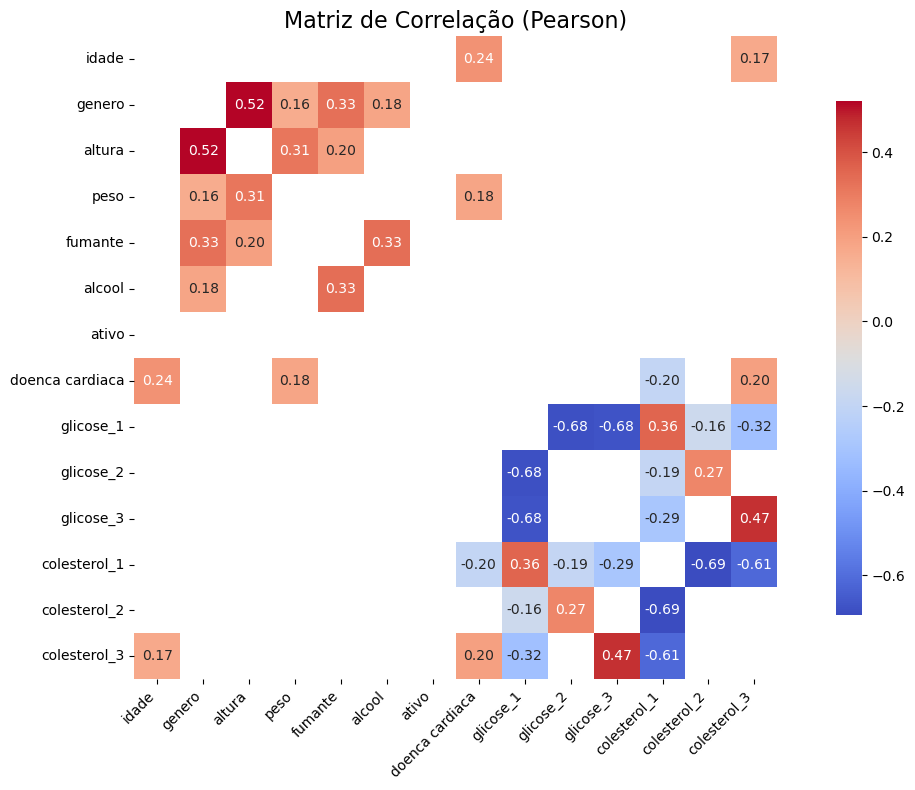

In [14]:
correlacao(df)

**Doenças cardíacas**

Observa-se uma correlação moderada (0,24) entre idade e doenças cardíacas: quanto maior a idade, maior a probabilidade de um diagnóstico positivo. Resultados semelhantes foram encontrados para colesterol alto (0,20) e peso (0,18). 
Por outro lado, gênero, tabagismo, consumo de álcool e nível de glicose não apresentaram correlação significativa com o diagnóstico positivo ou negativo de doenças cardiovasculares.


## **Separando base de dados**

In [18]:
# Base de treino e teste
X = df.drop(['doenca cardiaca'], axis=1) 
y = df['doenca cardiaca'] 
print(f"Tamanho de X: {X.shape}")

# Separação das bases de treino e test.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

print(f"Base de Treino X: {X_train.shape}")
print(f"Base de Teste  X: {X_test.shape}")
print(f"Base de Treino y: {y_train.shape}")
print(f"Base de Teste  y: {y_test.shape}")

# Padronização dos dados
sc=StandardScaler()
X_train = sc.fit_transform(X_train)   
X_test = sc.transform(X_test)

# Balanceamento da com SMOTE
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

Tamanho de X: (9691, 13)
Base de Treino X: (7268, 13)
Base de Teste  X: (2423, 13)
Base de Treino y: (7268,)
Base de Teste  y: (2423,)


## **Treinamento do modelo**

In [19]:
# Modelo de regressão logistica
logistic_cardio = LogisticRegression()
logistic_cardio.fit(X_train, y_train)

LogisticRegression()

In [20]:
print('Intercept:',logistic_cardio.intercept_[0])
print('coeficientes:',*logistic_cardio.coef_[0])

Intercept: 0.014083056838735761
coeficientes: 0.3876210410904365 0.03735379255657182 -0.10945047544552987 0.37340396505785456 -0.03388663129936028 -0.01659024455481489 -0.09596407522929395 0.03331806118679608 0.03418932530504701 -0.08025586301304002 -0.20702768264450466 -0.0023964393801837397 0.2867891845211953




Relatório de Classificação 

              precision    recall  f1-score   support

           0       0.63      0.67      0.65      3667
           1       0.65      0.60      0.62      3667

    accuracy                           0.63      7334
   macro avg       0.64      0.63      0.63      7334
weighted avg       0.64      0.63      0.63      7334



Matriz de confusão



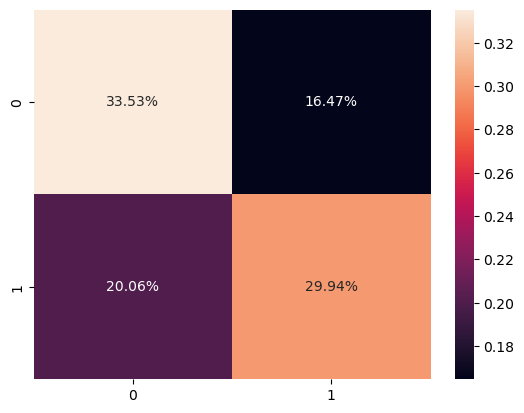

In [39]:
# Relatorio e matriz de confusão
prev_train=logistic_cardio.predict(X_train)
print("\n\nRelatório de Classificação \n")
print(classification_report(y_train, prev_train))

print("\n\nMatriz de confusão\n")
cm = confusion_matrix(y_train, prev_train)
sns.heatmap(cm / cm.sum(), annot=True, fmt='.2%')
plt.show()

## **Teste do modelo**

Relatório de Classificação TESTE
              precision    recall  f1-score   support

           0       0.62      0.69      0.66      1198
           1       0.66      0.60      0.63      1225

    accuracy                           0.64      2423
   macro avg       0.64      0.64      0.64      2423
weighted avg       0.64      0.64      0.64      2423

Matriz de confusão


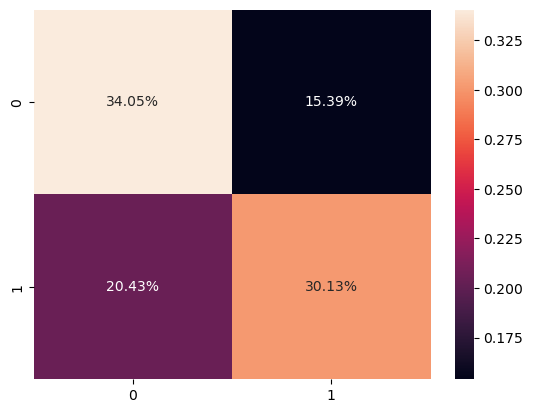

In [40]:
# Relatorio e matriz de confusão  - TESTE
prev_test=logistic_cardio.predict(X_test)
print("Relatório de Classificação TESTE")
print(classification_report(y_test, prev_test))
cm = confusion_matrix(y_test, prev_test)
print("Matriz de confusão")
sns.heatmap(cm / cm.sum(), annot=True, fmt='.2%')
plt.show()

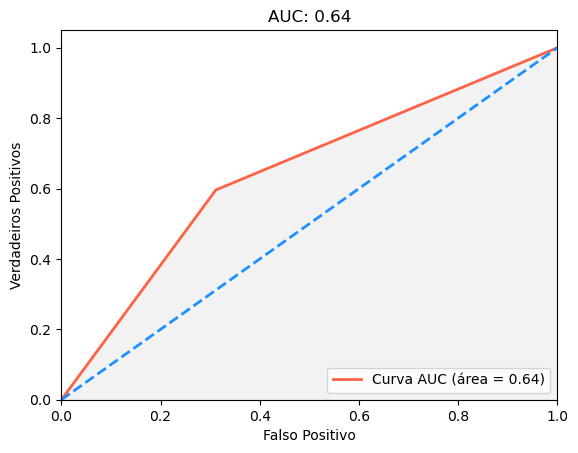

In [43]:
# Curva ROC e AUC

fpr, tpr, thresholds = roc_curve(y_test, prev_test)
roc_auc = roc_auc_score(y_test, prev_test)

plt.figure()
plt.plot(fpr, tpr, color='tomato', lw=2, label='Curva AUC (área = %0.2f)' % roc_auc)
plt.fill_between(fpr, tpr, color='grey', alpha=0.1) 
plt.plot([0, 1], [0, 1], color='dodgerblue', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Falso Positivo')
plt.ylabel('Verdadeiros Positivos')
plt.title(f"AUC: {roc_auc:.2f}")
plt.legend(loc="lower right")
plt.show()

Com base nos resultados de treino e teste, é possível afirmar que o modelo apresenta desempenho consistente entre os dois conjuntos de dados, mantendo a acurácia próxima de 60% em ambos os casos, indicanbdo que nao houve overfiting. As métricas por classe mostram um padrão semelhante: para a classe 0 (saudável) e 1 (doença cardíaca), ambas mantiveram-se estáveis.

O AUC de 0,64 confirma que o modelo possui poder preditivo limitado para aplicações médicas. Embora apresente consistência entre treino e teste, seu desempenho ainda está abaixo do desejável.

## **Explicando**

**O que é regressão logística** \
Regressão logística é uma técnica estatística utilizada para prever ou classificar resultados binários (“Sim/Não” ou “0/1”), a partir de um conjunto de variáveis preditoras. Ela permite calcular a probabilidade de um evento ocorrer por meio de uma função sigmoide, que transforma valores contínuos em probabilidades entre 0 e 1. Com base nessas probabilidades e nos coeficientes estimados, é definido se o resultado final será 0 ou 1.

**Por que a regressão logística é um modelo de classificação** \
A regressão logística é considerada um modelo de classificação porque seu objetivo não é prever valores contínuos, mas atribuir uma categoria a partir de informações probabilísticas. O modelo calcula a probabilidade de cada classe, e a decisão final é tomada com base em um limiar (threshold). Por exemplo, usando o limiar padrão de 0,5, probabilidades ≥ 0,5 são classificadas como 1, enquanto valores menores que 0,5 são classificados como 0.